# Segmentation with Image Processing

Pouya Pourakbarian Niaz  
Date: 2020-09-25  
email: pniaz20@ku.edu.tr

Here we will perform cell segmentation and vessel segmentation without using deep learning. Only OpenCV will be used.

### Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tqdm import tqdm
import json
import random
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

### Function Definitions

The definitions of all functions used throughout the assignment is here in this cell.

In [2]:
def ObtainForegroundMask(image_path:str, save_path:str=None, show:bool=True, save:bool=True, return_images:bool=True,
    structuring_element_type:int=cv2.MORPH_ELLIPSE, structuring_element_size:tuple=(1,1), morph:int=cv2.MORPH_OPEN,
    distance_transform_type:int=cv2.DIST_L2, distance_transform_size:int=3, sure_fg_thresh_min:float=0.05, figsize:tuple=(10,5)):
    """Obtain the binary foreground mask of a cell segmentation image.

    Args:
    
        image_path (str): path to the image.
        save_path (str, optional): path to where the result should be saved. Defaults to None.
        show (bool, optional): Show the images after generating them. Defaults to True.
        save (bool, optional): Save the results after generating them. Defaults to True.
        return_images (bool, optional): Return all internal images after generating them. Defaults to True.
        structuring_element_type (int, optional): Type of structuring element for morphology. Defaults to cv2.MORPH_ELLIPSE.
        structuring_element_size (tuple, optional): Element size for morphology. Defaults to (1,1).
        morph (int, optional): Type of morphological operation. Defaults to cv2.MORPH_OPEN.
        distance_transform_type (int, optional): Type of distance transform. Defaults to cv2.DIST_L2.
        distance_transform_size (int, optional): Size of distance transform filter. Defaults to 3.
        sure_fg_thresh_min (float, optional): Minimum relative threhshold for final binarization of the mask. Defaults to 0.05.
        figsize (tuple, optional): Figure size for displaying the images. Defaults to (10,5).

    Returns:
        dict: Dictionary of internal variables and the final image, with the following fields:
        image: The image itself
        foreground_mask: the binary foreground mask
        binarized_image: the binarized image
        morphed_image: the result of morphological operations
        distance_transform: the distance transform
    """
    
    # Load the image
    img = cv2.imread(image_path)

    # Grayscale and binarize the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(structuring_element_type, structuring_element_size)
    opening = cv2.morphologyEx(thresh, morph, kernel)

    # Apply distance transform to create a distance map
    dist_transform = cv2.distanceTransform(opening, distance_transform_type, distance_transform_size)
    _, sure_fg = cv2.threshold(dist_transform, sure_fg_thresh_min*dist_transform.max(), 255, cv2.THRESH_BINARY)

    # Invert the foreground mask
    sure_fg = 1 - sure_fg/255

    if show:
        # Show the original image and the foreground mask in two subplots
        fig, ax = plt.subplots(1, 2, figsize=figsize)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Original Image')
        # ax[0].axis('off')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].imshow(sure_fg, cmap='gray')
        ax[1].set_title('Foreground Mask')
        # ax[1].axis('off')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        fig.tight_layout()
        # plt.show()

    if save:
        # Save the foreground mask
        cv2.imwrite(save_path, sure_fg*255)
    
    if return_images:
        return {'image': img, 'foreground_mask': sure_fg, 'binarized_image':thresh, 'morphed_image':opening, 'distance_transform':dist_transform}



def calc_foreground_masking_metrics(gt_path:str, pred_path:str, saveto:str):
    """Calculate the metrics of an applied foregraound mask.

    Args:
        gt_path (str): path to the .txt file containing gold standard (ground truth) foreground mask.
        pred_path (str): path to the .jpg file containing predicted foreground mask.
        saveto (str): path to where the result should be saved.
        
        
    Returns:
        dictionary containing the `precision`, `recall`, `accuracy`, and `f1` score.
    """
    # Load the ground truth and predicted foreground masks
    gt = np.genfromtxt(gt_path, delimiter=' ')
    pred = cv2.cvtColor(cv2.imread(pred_path), cv2.COLOR_BGR2GRAY)
    _, pred = cv2.threshold(pred, 128, 255, cv2.THRESH_BINARY)
    pred = pred / 255.0
    
    # Calculate the metrics
    precision = precision_score(gt.flatten(), pred.flatten())
    recall = recall_score(gt.flatten(), pred.flatten())
    accuracy = accuracy_score(gt.flatten(), pred.flatten())
    f1 = f1_score(gt.flatten(), pred.flatten())

    # Print the metrics
    print("----------------------------------------")
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('Accuracy: {:.4f}'.format(accuracy))
    print('F1 score: {:.4f}'.format(f1))
    print("----------------------------------------")
    
    # Show the images in two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(gt, cmap='gray', vmin=0, vmax=1)
    ax[0].set_title('Ground Truth')
    # ax[0].axis('off')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(pred, cmap='gray')
    ax[1].set_title('Calculated')
    # ax[1].axis('off')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # plt.show()
    fig.tight_layout()
    fig.savefig(saveto, dpi=300)
    
    return {'precision':precision, 'recall':recall, 'accuracy':accuracy, 'f1':f1}



def FindCellLocations(image_file:str, mask_file:str, image_threshold:int=200, distance_type:int=cv2.DIST_L2, distance_size:int=3, maxima_relative_threshold:float=0.5,
                      remove_noise:bool=False, structuring_element_type:int=cv2.MORPH_ELLIPSE, structuring_element_size:tuple=(1,1), morph:int=cv2.MORPH_OPEN):
    """Find cell locations in a cell segmentation image.

    Args:
        image_file (str): path to the image file.
        mask_file (str): path to the binary foreground mask file.
        image_threshold (int, optional): binarization threshold. Defaults to 200.
        distance_type (int, optional): Type of distance transform. Defaults to cv2.DIST_L2.
        distance_size (int, optional): Filter size of distance transform. Defaults to 3.
        maxima_relative_threshold (float, optional): Relative threshold for extracting local maxima after distance transform. Defaults to 0.5.
        remove_noise (bool, optional): Remove noise via morphological operation. Defaults to False.
        structuring_element_type (int, optional): Structuring element type fpr denoising. Defaults to cv2.MORPH_ELLIPSE.
        structuring_element_size (tuple, optional): Elenment size for denoising operation. Defaults to (1,1).
        morph (int, optional): Type of morphological operation for denoising. Defaults to cv2.MORPH_OPEN.

    Returns:
        dict: Dictionary containing the following fields:
        local_maxima: The binary local maxima map after distance transform.
        contours: list of contours extracted from the local maxima map.
        centroids: centroid coordinates of the cells
        bgr_image: the BGR original image
        gray_image: the gray-scale original image
        foreground_mask: the binary foreground mask
        binarized_image: the binarized image
        opening: result of the opening operation
        distance_transform: the distance transform
        num_cells: number of cells
        labels: the labeled image
        stats: the stats of the labeled image, from `cv2.connectedComponentsWithStats`
    """
    
    # Load image and mask using OpenCV
    bgr_image = cv2.imread(image_file)
    fg_mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    
    # Binarize the mask, just in case.
    _, fg_mask = cv2.threshold(fg_mask, 128, 255, cv2.THRESH_BINARY)
    
    # Grayscale and inverse-binarize the RGB image to make boundaries white and everything else black.
    gray_img = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, image_threshold, 255, cv2.THRESH_BINARY_INV)
    binary_img[fg_mask==fg_mask.min()] = 0
    
    # Apply morphological operations to remove noise
    if remove_noise:
        kernel = cv2.getStructuringElement(structuring_element_type, structuring_element_size)
        opening = cv2.morphologyEx(binary_img, morph, kernel)
    else:
        opening = binary_img
    
    # Calculate distance transform with respect to the white boundaries
    dist_transform = cv2.distanceTransform(opening, distance_type, distance_size)
    
    # Threshold the distance transform to obtain the peaks
    _, peaks = cv2.threshold(dist_transform, maxima_relative_threshold*dist_transform.max(), 255, cv2.THRESH_BINARY)
    peaks = peaks.astype(np.uint8)
    
    num_cells, labels, stats, cell_centers = cv2.connectedComponentsWithStats(peaks, connectivity=8, ltype=cv2.CV_32S)
    
    # Find contours of the peaks
    contours, _ = cv2.findContours(peaks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
     
    # # Find centroids of cells using average of pixel coordinates
    # cell_centers = []
    # for contour in contours:
    #     cx = int(np.average(contour[:, :, 0]))
    #     cy = int(np.average(contour[:, :, 1]))
    #     cell_centers.append((cx, cy))

    return {'local_maxima':peaks, 'contours':contours, 'centroids':cell_centers, 'bgr_image':bgr_image, 'gray_image':gray_img, 'foreground_mask':fg_mask,
            'binarized_image':binary_img, 'opening':opening, 'distance_transform':dist_transform,
            'num_cells':num_cells, 'labels':labels, 'stats':stats}




def evaluate_cell_detection(fg_mask_file:str, ground_truth_file:str, centroid_coords:np.ndarray):
    """Evaluate the cell detection performance

    Args:
        fg_mask_file (str): path to the file contianing the foreground mask image
        ground_truth_file (str): path to the file containing the ground truth text file
        centroid_coords (np.ndarray): numpy array of centroid coordinates of the cells

    Returns:
        dict: dictionary containing the following fields:
        accuracy, precision, recall, TP, FP, FN, f1
    """
    # Read the foreground mask
    fg_mask = cv2.imread(fg_mask_file, 0)

    # Load the ground truth and get the number of cells (N)
    # Open the ground truth text file
    with open(ground_truth_file, 'r') as f:
        lines = f.readlines()

    # Remove any empty lines
    lines = [line.strip() for line in lines if line.strip() != '']

    # Load the ground truth text file
    ground_truth = np.loadtxt(lines, delimiter=' ')
    N = int(ground_truth.max())

    # Initialize variables for true positives, false positives, and false negatives
    TP = 0
    FP = 0
    FN = N

    # Iterate over each centroid
    centroid_coords = centroid_coords.tolist()
    for coord in centroid_coords:
        x, y = coord
        x = int(round(x))
        y = int(round(y))

        # Check if the centroid falls in the foreground or background
        if fg_mask[y, x] == 255:
            # Find the cell ID corresponding to the centroid by looking up the ground truth label at that position
            cell_id = ground_truth[y, x]

            # Check if the cell is a false positive (i.e., background according to the ground truth)
            if cell_id == 0:
                FP += 1
            else:
                # Find all the pixels in the ground truth that belong to the cell
                cell_pixels = np.where(ground_truth == cell_id)

                # Check if any of these pixels match another centroid in the list
                matches = False
                for i in range(len(centroid_coords)):
                    if i == centroid_coords.index(coord):
                        continue

                    x2, y2 = centroid_coords[i]
                    if any(np.logical_and(cell_pixels[0] == y2, cell_pixels[1] == x2)):
                        matches = True
                        break

                # If the cell matches only one centroid, it is a true positive
                if not matches:
                    TP += 1
                    FN -= 1

    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)

    # Calculate accuracy based on the number of cells that match a centroid in the list
    accuracy = TP / N

    return {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'TP':TP, 'FP':FP, 'FN':FN, 'f1':f1_score}




def FindCellBoundaries(cell_data:dict, push_to_zero:bool=True):
    """Segment cells using watershed algorithm

    Args:
        cell_data (dict): dictionary containing the following fields:
            bgr_image, foreground_mask, labels
        push_to_zero (bool, optional): Push the segmentation map to zero foreground so labels are 1 to N. Defaults to True.

    Returns:
        dict: dictionary containing the following fields:
            segmentation: resulting segmentation map, markers: initial markers before watershed
    """
    
    img = cell_data['bgr_image'].copy()
    foreground_mask = cell_data['foreground_mask'].copy()
    labels = cell_data['labels'].copy() + 1
    
    # Construct the markers
    markers = labels.copy()
    markers[(foreground_mask==foreground_mask.max()) & (labels==1)] = 0
    init_markers = markers.copy()
    
    # Apply watershed algorithm to segment the cells
    segmentation = cv2.watershed(img, markers)
    
    # Set the background pixels to 0
    if push_to_zero:
        segmentation[segmentation < 1] = 1
        segmentation = segmentation - 1
    
    # Return the segmentation map
    return {'segmentation':segmentation, 'markers':init_markers}




def generate_random_colors(num_colors:int):
    """Generate as many random colors as you want.

    Args:
        num_colors (int): number of colors to generate

    Returns:
        list: list of [R,G,B] colors
    """
    colors = []
    for i in range(num_colors):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])
    return colors




def evaluate_segmentation(ground_truth_file:str, segmentation_results:dict, thresholds:list=[0.5,0.75,0.9]):
    """Evaluate the performance of the cell segmentation function.

    Args:
        ground_truth_file (str): path to the ground truth labels text file.
        segmentation_results (dict): dictionary containing the 'segmentation' field.
        thresholds (list, optional): List containing IOU thresholds to evaluate. Defaults to [0.5,0.75,0.9].

    Returns:
        dict: dictionary containing the following fields:
        'dice_index': the dice index,  
        
        // object-level metrics where 50% mutual overlap (IOU = 1/3) is considered a true positive //
        'precision_f': object-level precision, 
        'recall_f': object-level recall, 
        'fscore_f': object-level f-score,  
        
        // object-level metrics where IOU >= thresh is considered a true positive // 
        'precision_iou': object-level precision per threshold, 
        'recall_iou': object-level recall per threshold,
        'fscore_iou': object-level f-score per threshold,
        'fscore_iou_average': average object-level f-score across all thresholds.
    """
    
    
    print("Preliminaries ...")
    
    seg_map = segmentation_results['segmentation'].astype(int)
    assert not np.any(seg_map < 0), "Segmentation map contains negative values. Did you mistakenly set `push_to_zero=False` in FindCellBoundaries() ?"
    
    # Load the ground truth and get the number of cells (N)
    # Open the ground truth text file
    with open(ground_truth_file, 'r') as f:
        lines = f.readlines()
    # Remove any empty lines
    lines = [line.strip() for line in lines if line.strip() != '']
    # Load the ground truth text file
    gt_map = np.loadtxt(lines, delimiter=' ').astype(int)
    
    seg_labels = np.unique(seg_map)
    gt_labels = np.unique(gt_map)

    # Remove background label (0)
    seg_labels = seg_labels[1:]
    gt_labels = gt_labels[1:]

    # Initialize metrics
    tp_f = 0
    fp_f = 0
    tp_iou = [0] * len(thresholds)
    fp_iou = [0] * len(thresholds)
    fn_iou = [0] * len(thresholds)
    precision_iou = [0] * len(thresholds)
    recall_iou = [0] * len(thresholds)
    fscore_iou = [0] * len(thresholds)
    sum_seg_sizes = np.sum(seg_map > 0)
    sum_gt_sizes = np.sum(gt_map > 0)
    seg_sums = 0
    gt_sums = 0

    
    # Go through the segmentation map
    print("Going through the segmentation map ...")
    for i in tqdm(range(len(seg_labels)), ncols=100):
        seg_label = seg_labels[i]
        seg_mask = seg_map == seg_label
        segsize = np.sum(seg_mask)
        gt_overlaps = []
        for gt_label in gt_labels:
            gt_mask = gt_map == gt_label
            intersection = np.logical_and(seg_mask, gt_mask).sum()
            if intersection == 0:
                continue
            union = np.logical_or(seg_mask, gt_mask).sum()
            iou = intersection / union
            gt_overlaps.append((gt_label, iou, intersection, union))
        if len(gt_overlaps) == 0:
            fp_f += 1
            for t in range(len(thresholds)):
                fp_iou[t] += 1
        else:
            gt_label, iou, intersection, union = max(gt_overlaps, key=lambda x: x[1])
            gt_mask = gt_map == gt_label
            gtsize = np.sum(gt_mask)
            # Calculate dice-index-related metrics
            seg_sums += (2*segsize*intersection/(segsize+gtsize))
            # Calculate object-level metrics
            if iou >= (1.0/3.0): # 50% mutual overlap
                tp_f += 1
            else:
                fp_f += 1
            # Calculate IOU-related metrics
            for t in range(len(thresholds)):
                if iou >= thresholds[t]:
                    tp_iou[t] += 1
                else:
                    fp_iou[t] += 1
    
            
    # Go through the ground truth map
    print("Going through the ground truth map to calculate the dice index metrics ...")
    for i in tqdm(range(len(gt_labels)), ncols=100):
        gt_label = gt_labels[i]
        gt_mask = gt_map == gt_label
        gtsize = np.sum(gt_mask)
        seg_overlaps = []
        for seg_label in seg_labels:
            seg_mask = seg_map == seg_label
            intersection = np.logical_and(gt_mask, seg_mask).sum()
            if intersection == 0:
                continue
            union = np.logical_or(seg_mask, gt_mask).sum()
            iou = intersection / union
            seg_overlaps.append((seg_label, iou, intersection))
        if len(seg_overlaps) > 0:
            seg_label, iou, intersection = max(seg_overlaps, key=lambda x: x[1])
            seg_mask = seg_map == seg_label
            segsize = np.sum(seg_mask)
            # Calculate dice-index-related metrics
            gt_sums += (2*gtsize*intersection/(segsize+gtsize))
    
    
    dice_index = 0.5*(seg_sums/sum_seg_sizes + gt_sums/sum_gt_sizes)
    fn_f = len(gt_labels) - tp_f
    precision_f = tp_f / (tp_f + fp_f)
    recall_f = tp_f / (tp_f + fn_f)
    fscore_f = (2 * (precision_f * recall_f) / (precision_f + recall_f)) if tp_f > 0 else 0
    
    for t in range(len(thresholds)):
        fn_iou[t] = len(gt_labels) - tp_iou[t]
        precision_iou[t] = tp_iou[t] / (tp_iou[t] + fp_iou[t])
        recall_iou[t] = tp_iou[t] / (tp_iou[t] + fn_iou[t])
        fscore_iou[t] = (2 * (precision_iou[t] * recall_iou[t]) / (precision_iou[t] + recall_iou[t])) if tp_iou[t] > 0 else 0
    
    fscore_iou_average = np.mean(fscore_iou)
    
    return {'dice_index':dice_index, 'precision_f':precision_f, 'recall_f':recall_f, 'fscore_f':fscore_f, 'precision_iou':precision_iou, 'recall_iou':recall_iou, 'fscore_iou':fscore_iou, 'fscore_iou_average':fscore_iou_average}





def segment_vessels(image_file:str, lense_mask_thresh:int=8, gauss_blur_size:tuple=(31,31), 
                    init_open_size:tuple=(3,3), close_size:tuple=(9,9), open_size:tuple=(3,3), area_thresh:int=150,
                    final_close_size:tuple=(11,11) , final_open_size:tuple=(3,3)):
    """Segment the vessels in a fundus image.

    Args:
        image_file (str): path to the image file
        lense_mask_thresh (int, optional): lense shutter mask binarization threshold. Defaults to 8.
        gauss_blur_size (tuple, optional): size of Gaussian blur filter. Defaults to (31,31).
        init_open_size (tuple, optional): Initial opening (for denoising) operation structuring element size. Defaults to (3,3).
        close_size (tuple, optional): Element size for closing. Defaults to (9,9).
        open_size (tuple, optional): Element size for opening. Defaults to (3,3).
        area_thresh (int, optional): Threshold for eliminating small regions. Defaults to 150.
        final_close_size (tuple, optional): Element size for final closing. Defaults to (11,11).
        final_open_size (tuple, optional): Element size for final opening. Defaults to (3,3).

    Returns:
        np.ndarray: The segmented image
    """
    
    # read the image
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)

    # Extract green channel
    green = img[:,:,1]
    # plt.figure()
    # plt.imshow(green, cmap='gray', vmin=0, vmax=255)
    # plt.title("Green")

    # Construct lense mask
    lense_mask = cv2.threshold(green, lense_mask_thresh, 255, cv2.THRESH_BINARY)[1]
    # plt.figure()
    # plt.imshow(lense_mask, cmap='gray', vmin=0, vmax=255)
    # plt.title("Lense Mask")

    # Apply gaussian blur
    blurred = cv2.GaussianBlur(green, gauss_blur_size, 0)
    # plt.figure()
    # plt.imshow(blurred, cmap='gray', vmin=0, vmax=255)
    # plt.title("Gaussian Blur")

    # divide gray by morphology image
    division = cv2.divide(green, blurred, scale=255)
    # plt.figure()
    # plt.imshow(division, cmap='gray', vmin=0, vmax=255)
    # plt.title("Division")

    # Remove the areas outisde the lense shutter
    division_masked = division.copy()
    division_masked[lense_mask == 0] = 255
    # plt.figure()
    # plt.imshow(division_masked, cmap='gray', vmin=0, vmax=255)
    # plt.title("Masked Division")


    # threshold
    thresh = cv2.threshold(division_masked, 0, 255, cv2.THRESH_OTSU)[1] 
    # plt.figure()
    # plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
    # plt.title("Threshold")

    # invert
    thresh = 255 - thresh
    # plt.figure()
    # plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
    # plt.title("Inverted Threshold")

    morphed = thresh.copy()

    # Opening
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, init_open_size))
    # plt.figure()
    # plt.imshow(morphed, cmap='gray', vmin=0, vmax=255)
    # plt.title("Opening")

    # Closing
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, close_size))
    # plt.figure()
    # plt.imshow(morphed, cmap='gray', vmin=0, vmax=255)
    # plt.title("Closing")

    # Opening
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, open_size))
    # plt.figure()
    # plt.imshow(morphed, cmap='gray', vmin=0, vmax=255)
    # plt.title("Opening")

    # find contours and discard contours with small areas
    mask = np.zeros_like(thresh)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > area_thresh:
            cv2.drawContours(mask, [cntr], -1, 255, 2)
    # plt.figure()
    # plt.imshow(mask, cmap='gray') 
    # plt.title("Masking")

    morphed = mask.copy()

    # Closing
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, final_close_size))
    # plt.figure()
    # plt.imshow(morphed, cmap='gray', vmin=0, vmax=255)
    # plt.title("Closing")

    # Opening
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, final_open_size))
    # plt.figure()
    # plt.imshow(morphed, cmap='gray', vmin=0, vmax=255)
    # plt.title("Opening")

    return morphed

### Show the images

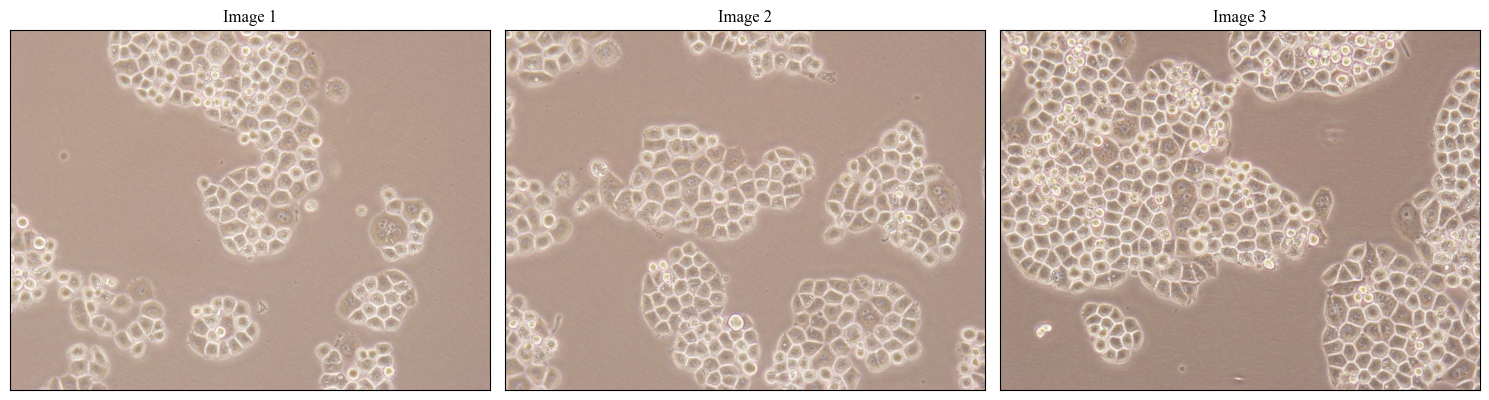

In [3]:
imagefiles = [f"data/im{i+1}.jpg" for i in range(3)]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    img = cv2.cvtColor(cv2.imread(imagefiles[i]), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image {}".format(i+1))
plt.tight_layout()
plt.savefig("data/three_images_together.png", dpi=300)

### Obtain Foreground Mask

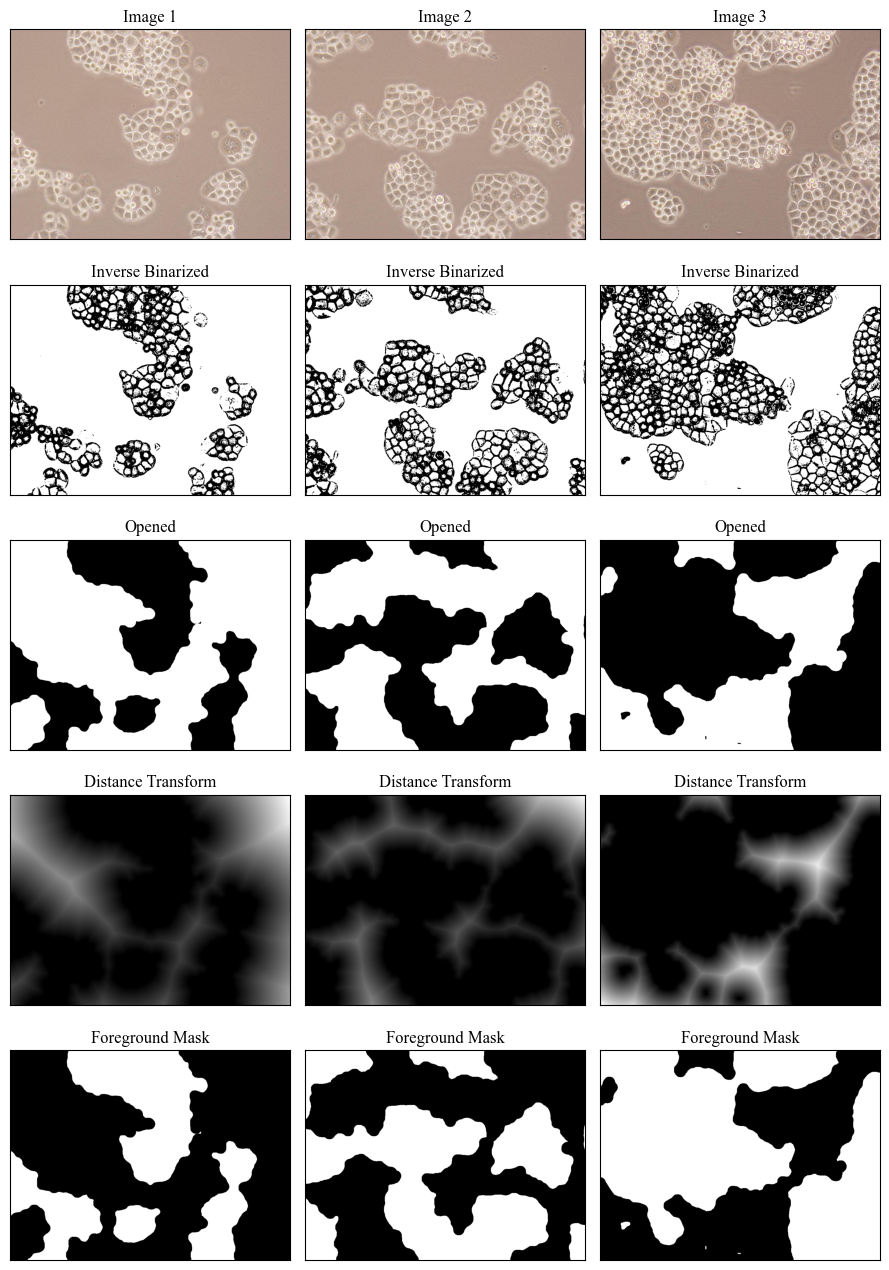

In [4]:
fg1 = []

for i in range(3):
    fg_ = ObtainForegroundMask(f"data/im{i+1}.jpg", f"data/im{i+1}_mask.jpg", sure_fg_thresh_min=0.00, show=False, 
        distance_transform_type=cv2.DIST_L2, distance_transform_size=0,
        structuring_element_type=cv2.MORPH_ELLIPSE, structuring_element_size=(40,40), morph=cv2.MORPH_OPEN)
    fg1.append(fg_)

# Show the images in subplots
fig, ax = plt.subplots(5, 3, figsize=(9,13))
for i in range(3):
    
    ax[0, i].imshow(cv2.cvtColor(fg1[i]['image'], cv2.COLOR_BGR2RGB))
    ax[0, i].set_title('Image {}'.format(i+1))
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    
    ax[1, i].imshow(fg1[i]['binarized_image'], cmap='gray')
    ax[1, i].set_title('Inverse Binarized')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    
    ax[2, i].imshow(fg1[i]['morphed_image'], cmap='gray')
    ax[2, i].set_title('Opened')
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])
    
    ax[3, i].imshow(fg1[i]['distance_transform'], cmap='gray')
    ax[3, i].set_title('Distance Transform')
    ax[3, i].set_xticks([])
    ax[3, i].set_yticks([])
    
    ax[4, i].imshow(fg1[i]['foreground_mask'], cmap='gray')
    ax[4, i].set_title('Foreground Mask')
    ax[4, i].set_xticks([])
    ax[4, i].set_yticks([])
    
fig.tight_layout()
fig.savefig("data/foreground_masks.png", dpi=300)

### Evaluate Foreground Mask

----------------------------------------
Precision: 0.8916
Recall: 0.9984
Accuracy: 0.9637
F1 score: 0.9420
----------------------------------------
----------------------------------------
Precision: 0.9357
Recall: 0.9891
Accuracy: 0.9663
F1 score: 0.9617
----------------------------------------
----------------------------------------
Precision: 0.9738
Recall: 0.9894
Accuracy: 0.9775
F1 score: 0.9815
----------------------------------------


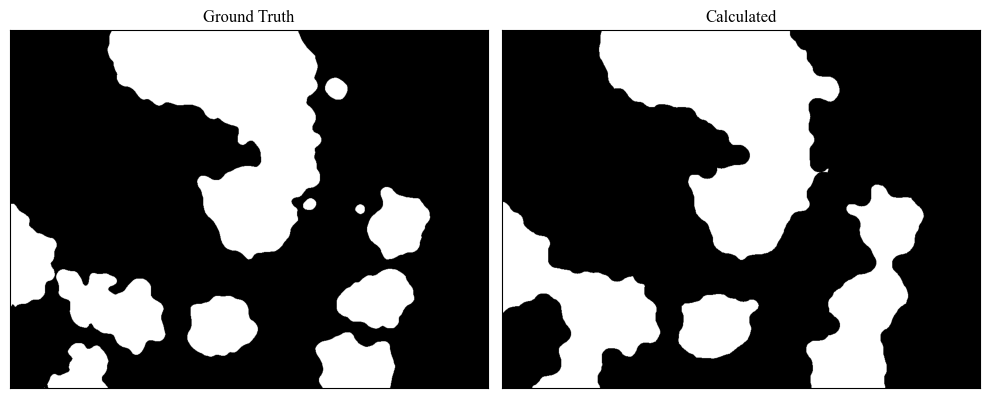

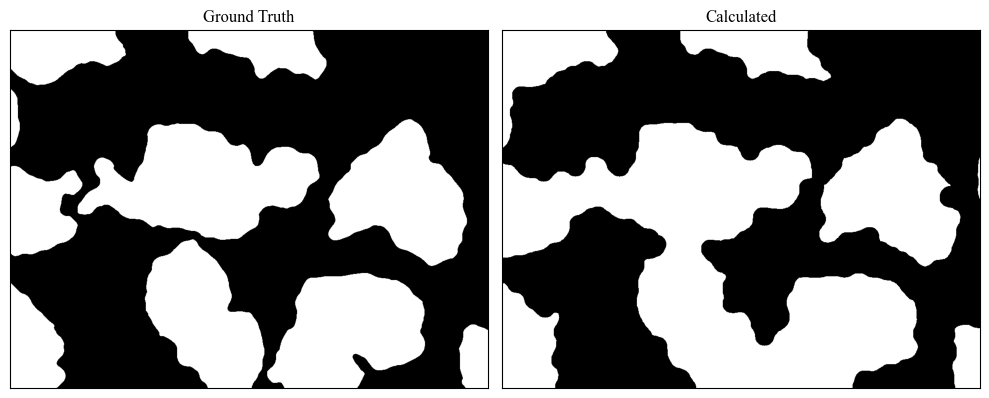

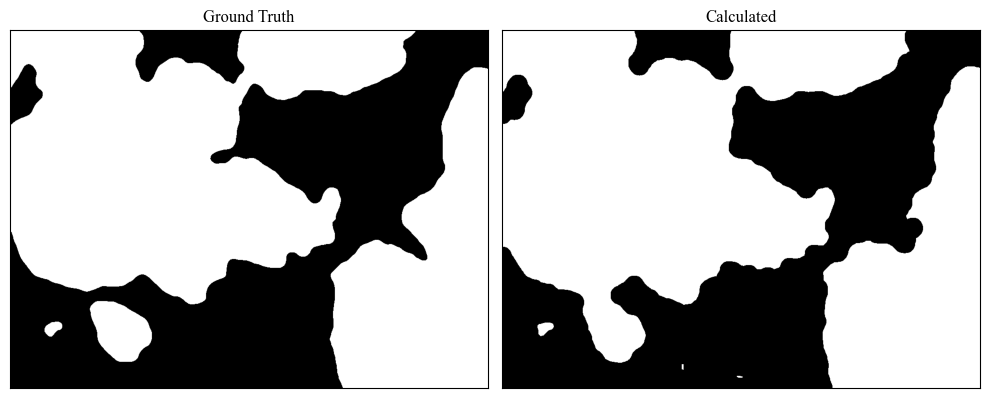

In [5]:
fgmetr1 = []
for i in range(3):
    metr = calc_foreground_masking_metrics(f"data/im{i+1}_gold_mask.txt", f"data/im{i+1}_mask.jpg", f"data/foreground_metrics_{i+1}.png")
    fgmetr1.append(metr)

### Locate and Separate Cells

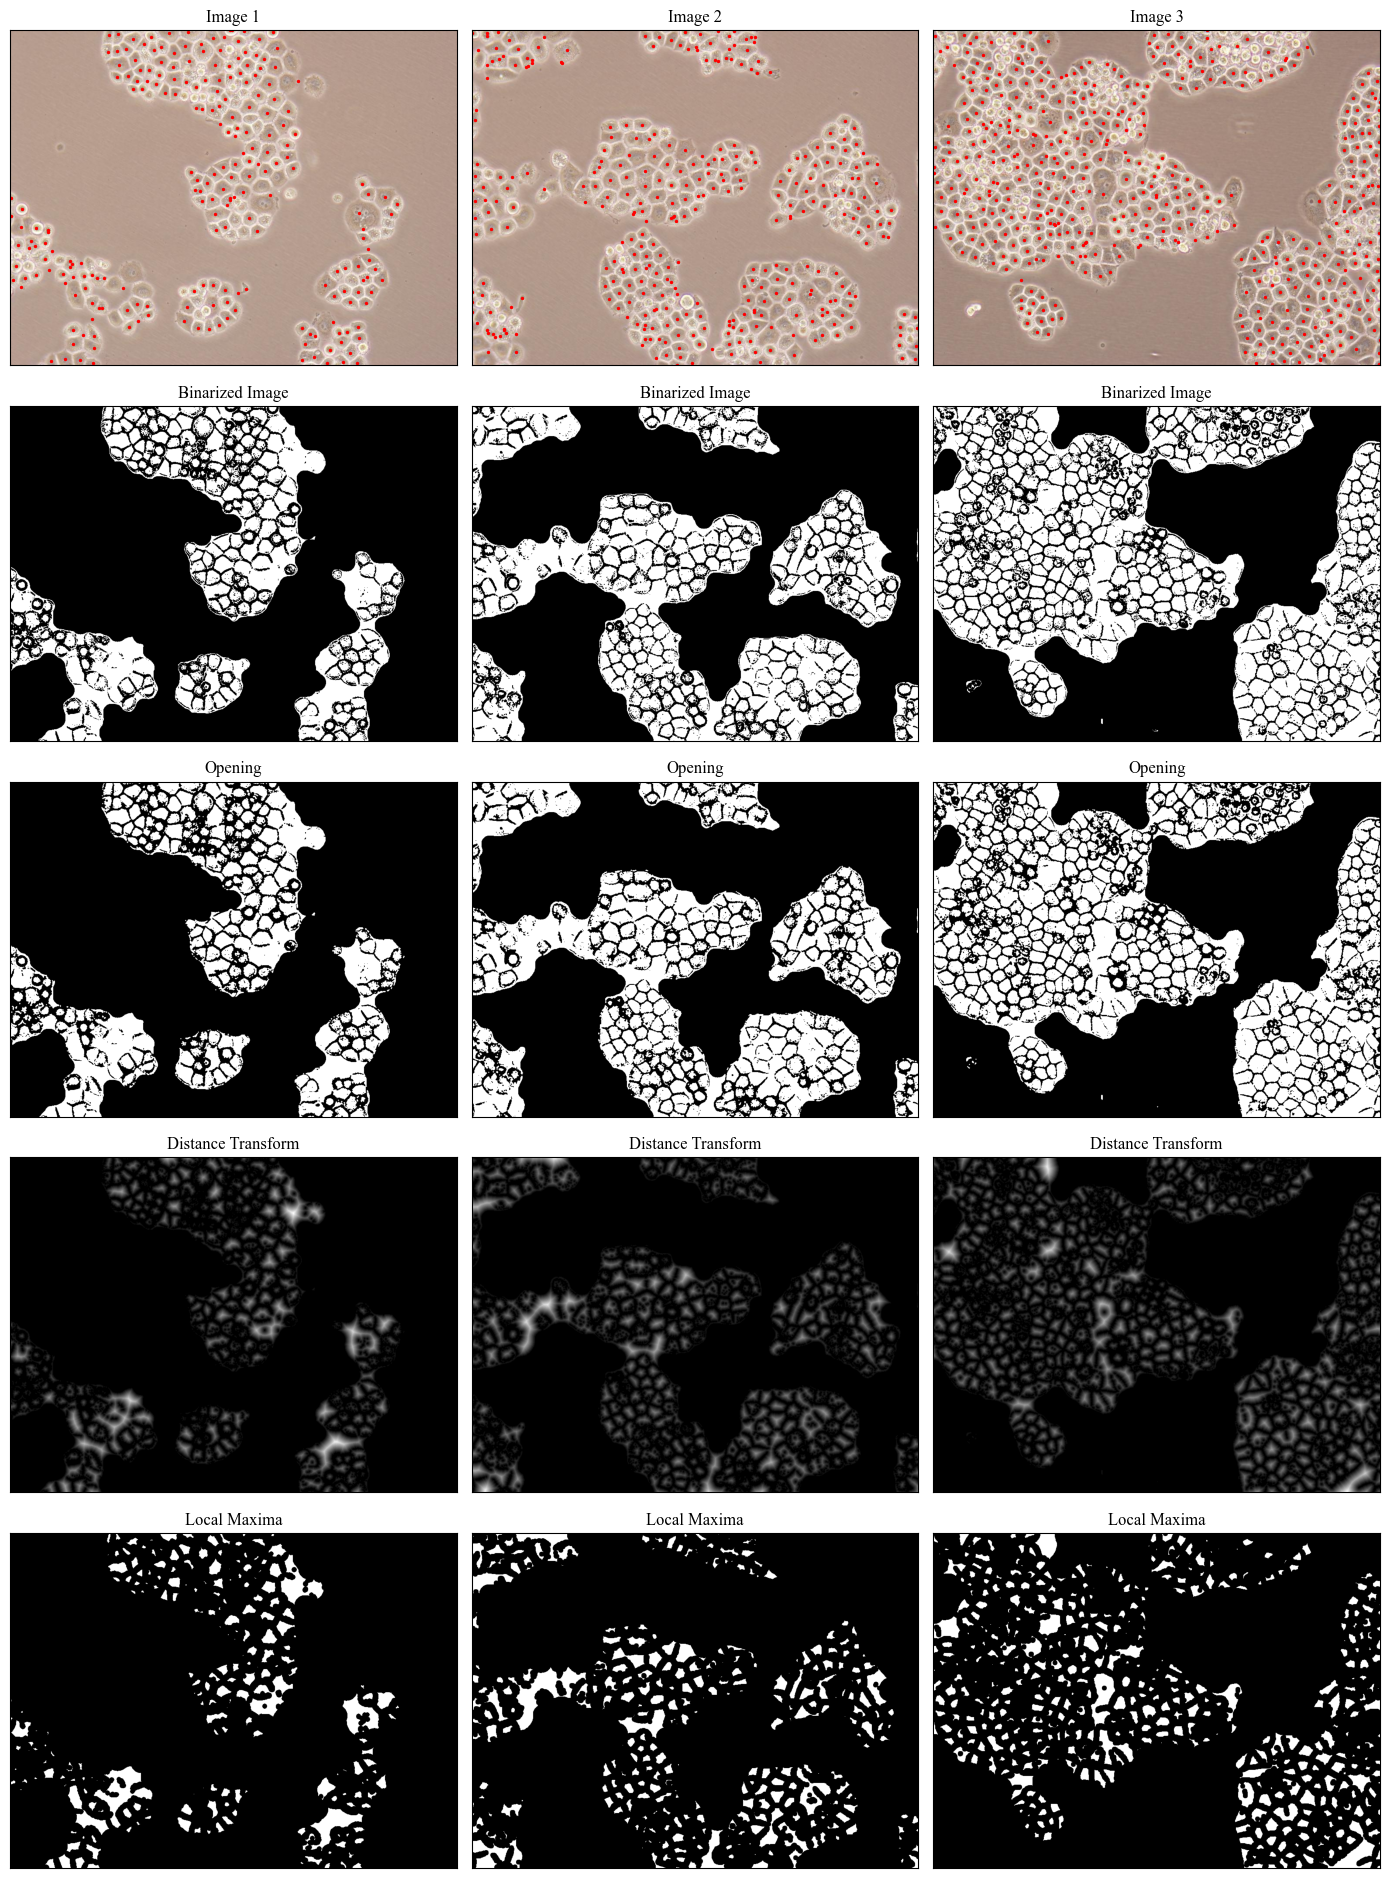

In [6]:
celldata = []
for i in range(3):
    celldata.append(FindCellLocations(f"data/im{i+1}.jpg", f"data/im{i+1}_mask.jpg", 
        image_threshold=200, distance_type=cv2.DIST_L2, distance_size=5, maxima_relative_threshold=0.2,
        remove_noise=True, structuring_element_type=cv2.MORPH_ELLIPSE, structuring_element_size=(3,3), morph=cv2.MORPH_OPEN))


fig, ax = plt.subplots(5, 3, figsize=(14, 19))
for i in range(3):
    ax[0, i].imshow(cv2.cvtColor(cv2.imread("data/im{}.jpg".format(i+1)), cv2.COLOR_BGR2RGB))
    ax[0, i].set_title('Image {}'.format(i+1))
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[0, i].scatter([x[0] for x in celldata[i]['centroids']], [x[1] for x in celldata[i]['centroids']], s=2, c='r')
    
    ax[1, i].imshow(celldata[i]['binarized_image'], cmap='gray')
    ax[1, i].set_title('Binarized Image')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    
    ax[2, i].imshow(celldata[i]['opening'], cmap='gray')
    ax[2, i].set_title('Opening')
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])
    
    ax[3, i].imshow(celldata[i]['distance_transform'], cmap='gray')
    ax[3, i].set_title('Distance Transform')
    ax[3, i].set_xticks([])
    ax[3, i].set_yticks([])
    
    ax[4, i].imshow(celldata[i]['local_maxima'], cmap='gray')
    ax[4, i].set_title('Local Maxima')
    ax[4, i].set_xticks([])
    ax[4, i].set_yticks([])
    
    
fig.tight_layout()
fig.savefig("data/cell_locations.png", dpi=300)

### Evaluate Cell Location

In [7]:
cellmetr = []
for i in range(3):
    print("\n=========================================")
    print(f"Evaluating Image {i+1} cell detection performance:\n")
    cellmetr.append(evaluate_cell_detection(f"data/im{i+1}_mask.jpg", f"data/im{i+1}_gold_cells.txt", celldata[i]['centroids']))
    print(cellmetr[i])


Evaluating Image 1 cell detection performance:

{'accuracy': 0.7933884297520661, 'precision': 0.9014084507042254, 'recall': 0.7933884297520661, 'TP': 192, 'FP': 21, 'FN': 50, 'f1': 0.843956043956044}

Evaluating Image 2 cell detection performance:

{'accuracy': 0.8392282958199357, 'precision': 0.8613861386138614, 'recall': 0.8392282958199357, 'TP': 261, 'FP': 42, 'FN': 50, 'f1': 0.8501628664495113}

Evaluating Image 3 cell detection performance:

{'accuracy': 0.7721021611001965, 'precision': 0.891156462585034, 'recall': 0.7721021611001965, 'TP': 393, 'FP': 48, 'FN': 116, 'f1': 0.8273684210526316}


### Segment Cells

In [8]:
seg = []
for i in range(3):
    seg.append(FindCellBoundaries(celldata[i]))

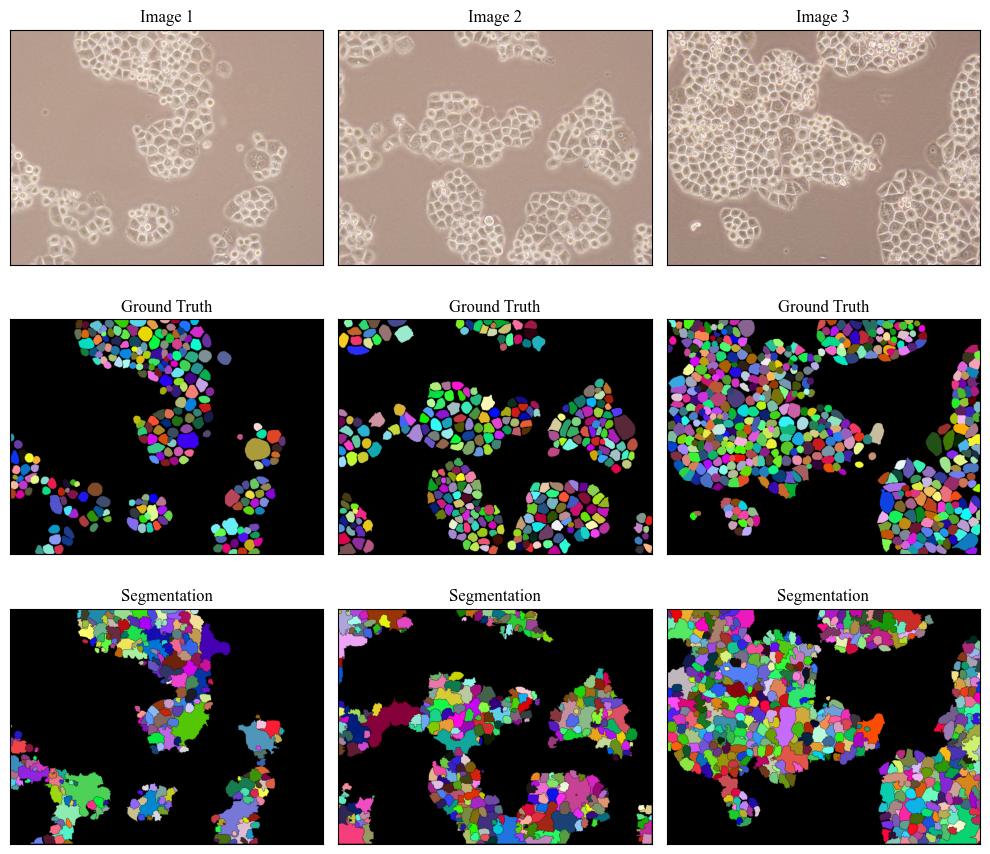

In [9]:
mySeg = []
fig, ax = plt.subplots(3, 3, figsize=(10, 9))

for i in range(3):
    
    ground_truth_file = f"data/im{i+1}_gold_cells.txt"
    with open(ground_truth_file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if line.strip() != '']
    gt = np.loadtxt(lines, delimiter=' ').astype(int)
    
    s = seg[i]['segmentation'].copy()
    colors_seg = generate_random_colors(s.max())
    out_seg = np.zeros_like(celldata[i]['bgr_image'])
    for j in range(s.max()):
        out_seg[s==(j+1)] = colors_seg[j]
    
    colors_gt = generate_random_colors(gt.max())
    out_gt = np.zeros_like(celldata[i]['bgr_image'])
    for j in range(gt.max()):
        out_gt[gt==(j+1)] = colors_gt[j]
    
    ax[0, i].imshow(cv2.cvtColor(celldata[i]['bgr_image'], cv2.COLOR_BGR2RGB))
    ax[0, i].set_title(f"Image {i+1}")
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    
    ax[1, i].imshow(out_gt)
    ax[1, i].set_title("Ground Truth")
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    
    ax[2, i].imshow(out_seg)
    ax[2, i].set_title("Segmentation")
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])
    
fig.tight_layout()
fig.savefig("data/colorful_segmentation.png", dpi=300)

### Evaluate Cell Segmentation

In [10]:
segmetr = []
thresholds = [0.5,0.75,0.9]
for i in range(3):
    print("\n===================================================")
    print(f"Calculating metrics for image {i+1} ...")
    metr = evaluate_segmentation(ground_truth_file=f"data/im{i+1}_gold_cells.txt", segmentation_results=seg[i], thresholds=[0.5,0.75,0.9])
    segmetr.append(metr)
    print("Dice index: ", metr['dice_index'])
    print("\nObject-level metrics-------------------------------")
    print("Precision: ", metr['precision_f'])
    print("Recall:    ", metr['recall_f'])
    print("F-score:   ", metr['fscore_f'])
    print("\nIOU metrics----------------------------------------")
    for j, thresh in enumerate(thresholds):
        print("\nThreshold: ", thresh)
        print("Precision: ", metr['precision_iou'][j])
        print("Recall:    ", metr['recall_iou'][j])
        print("F-score:   ", metr['fscore_iou'][j])
    print("\nAverage across thresholds: ")
    print("F-score:   ", metr['fscore_iou_average'])
    print("===================================================\n")


Calculating metrics for image 1 ...
Preliminaries ...
Going through the segmentation map ...


100%|█████████████████████████████████████████████████████████████| 223/223 [00:32<00:00,  6.92it/s]


Going through the ground truth map to calculate the dice index metrics ...


100%|█████████████████████████████████████████████████████████████| 242/242 [00:33<00:00,  7.17it/s]


Dice index:  0.6148347459670742

Object-level metrics-------------------------------
Precision:  0.7354260089686099
Recall:     0.6776859504132231
F-score:    0.7053763440860216

IOU metrics----------------------------------------

Threshold:  0.5
Precision:  0.48878923766816146
Recall:     0.45041322314049587
F-score:    0.4688172043010753

Threshold:  0.75
Precision:  0.18385650224215247
Recall:     0.16942148760330578
F-score:    0.1763440860215054

Threshold:  0.9
Precision:  0.004484304932735426
Recall:     0.004132231404958678
F-score:    0.004301075268817205

Average across thresholds: 
F-score:    0.21648745519713264


Calculating metrics for image 2 ...
Preliminaries ...
Going through the segmentation map ...


100%|█████████████████████████████████████████████████████████████| 338/338 [00:56<00:00,  5.98it/s]


Going through the ground truth map to calculate the dice index metrics ...


100%|█████████████████████████████████████████████████████████████| 311/311 [01:02<00:00,  4.94it/s]


Dice index:  0.6298381649453582

Object-level metrics-------------------------------
Precision:  0.6390532544378699
Recall:     0.6945337620578779
F-score:    0.6656394453004624

IOU metrics----------------------------------------

Threshold:  0.5
Precision:  0.48520710059171596
Recall:     0.5273311897106109
F-score:    0.5053929121725731

Threshold:  0.75
Precision:  0.16568047337278108
Recall:     0.18006430868167203
F-score:    0.17257318952234207

Threshold:  0.9
Precision:  0.0
Recall:     0.0
F-score:    0

Average across thresholds: 
F-score:    0.22598870056497175


Calculating metrics for image 3 ...
Preliminaries ...
Going through the segmentation map ...


100%|█████████████████████████████████████████████████████████████| 466/466 [02:08<00:00,  3.62it/s]


Going through the ground truth map to calculate the dice index metrics ...


100%|█████████████████████████████████████████████████████████████| 509/509 [02:20<00:00,  3.63it/s]

Dice index:  0.6671875014360914

Object-level metrics-------------------------------
Precision:  0.7618025751072961
Recall:     0.6974459724950884
F-score:    0.7282051282051283

IOU metrics----------------------------------------

Threshold:  0.5
Precision:  0.6180257510729614
Recall:     0.5658153241650294
F-score:    0.5907692307692307

Threshold:  0.75
Precision:  0.22746781115879827
Recall:     0.2082514734774067
F-score:    0.21743589743589742

Threshold:  0.9
Precision:  0.006437768240343348
Recall:     0.005893909626719057
F-score:    0.006153846153846154

Average across thresholds: 
F-score:    0.27145299145299145



### Perform and Evaluate Vessel Segmentation from Fundus Images

Metrics for image 1: 
Accuracy:   0.9415510713836873
Precision:  0.8410648963555074
Recall:     0.5649811609239338
F-score:    0.675917860720352
Metrics for image 2: 
Accuracy:   0.9460449525574965
Precision:  0.9354085455373867
Recall:     0.5972017970555439
F-score:    0.7289885091482962
Metrics for image 3: 
Accuracy:   0.9427926079238407
Precision:  0.7896719187814941
Recall:     0.6346021554689292
F-score:    0.7036953221742216


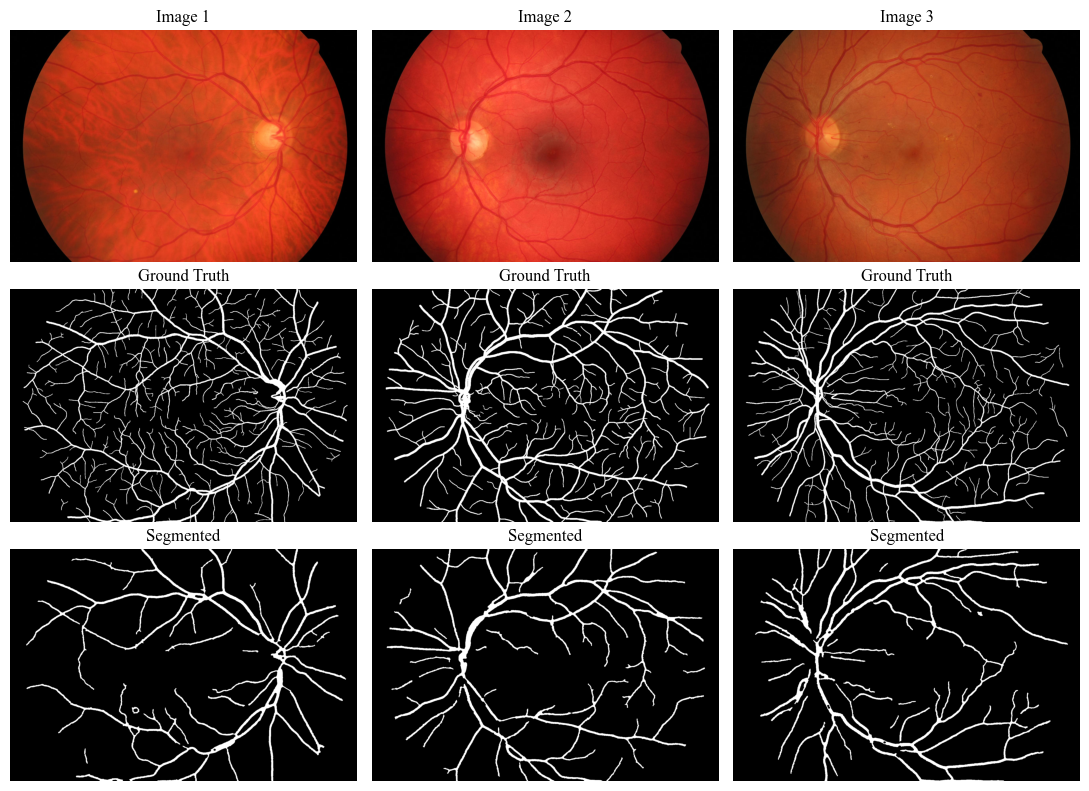

In [13]:
filenames = ["d11_g", "d4_h", "d7_dr"]
filenames_gt = [name+"_gold" for name in filenames]
fig, ax = plt.subplots(3, 3, figsize=(11, 8))
for i in range(3):
    image = cv2.cvtColor(cv2.imread("fundus/{}.jpg".format(filenames[i])), cv2.COLOR_BGR2RGB)
    vess_seg = segment_vessels("fundus/{}.jpg".format(filenames[i]))
    vess_gt = cv2.imread("fundus/{}.png".format(filenames_gt[i]), cv2.IMREAD_GRAYSCALE)
    vess_gt[vess_gt > 0] = 255
    
    ax[0, i].imshow(image)
    ax[0, i].set_title(f"Image {i+1}")
    ax[0, i].axis('off')
    
    ax[1, i].imshow(vess_gt, cmap='gray')
    ax[1, i].set_title("Ground Truth")
    ax[1, i].axis('off')
    
    ax[2, i].imshow(vess_seg, cmap='gray')
    ax[2, i].set_title("Segmented")
    ax[2, i].axis('off')
    
    tp = np.sum(np.logical_and(vess_gt, vess_seg))
    fp = np.sum(np.logical_and(np.logical_not(vess_gt), vess_seg))
    tn = np.sum(np.logical_and(np.logical_not(vess_gt), np.logical_not(vess_seg)))
    fn = np.sum(np.logical_and(vess_gt, np.logical_not(vess_seg)))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fscore = 2 * precision * recall / (precision + recall)
    
    print("Metrics for image {}: ".format(i+1))
    print("Accuracy:  ", accuracy)
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F-score:   ", fscore)
    
fig.tight_layout()
fig.savefig("fundus/fundus_segmentation.png", dpi=300)